In [2]:
import tensorflow as tf
import os
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
DATA_DIR ='/content/drive/MyDrive/Colab Notebooks/Kaggle cats & dog dataset/'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'training_set')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test_set')

In [5]:
IMG_SIZE = 224
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)



['dogs', 'cats']


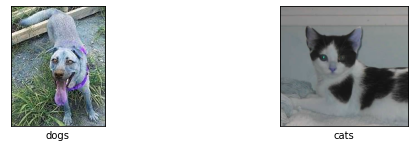

In [6]:


plt.figure(figsize=(20,20))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(10,5,i+1)
        plt.imshow(img_array)
        plt.xlabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        break

plt.tight_layout()        
plt.show()



In [7]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) #'/content/drive/MyDrive/Colab Notebooks/Kaggle cats & dog dataset/'
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) # [ [img, 0], [], [], [], ...., []]
        except Exception as e:
            pass
        
print(len(training_data))

100%|██████████| 1070/1070 [00:06<00:00, 159.81it/s]

2142


In [8]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass
        
print(len(test_data))



100%|██████████| 1012/1012 [00:06<00:00, 161.54it/s]

2023


In [9]:
random.shuffle(training_data)
random.shuffle(test_data)

In [10]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,224,224,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (2142, 224, 224, 3) Y_train= (2142,)


In [11]:


X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")



X_test= (2023, 224, 224, 3) Y_test= (2023,)


In [12]:
mean_rgb = np.mean(X_train, axis=(0,1,2))
print(mean_rgb)

[39.96174 39.96174 39.96174]


In [13]:
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)
for i in range(len(X_train)):
    for c in range(3):
        if(c==1):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[1]
        else:
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[2]
            
for i in range(len(X_test)):
    for c in range(3):
        if(c==1):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[1]
        else:
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[2]



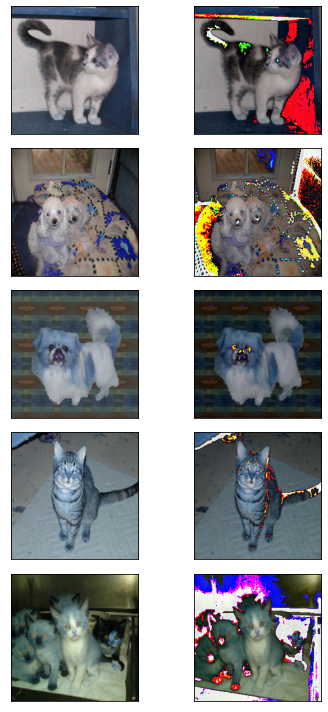

In [14]:
import matplotlib.pyplot as plt
c = 0
plt.figure(figsize=(6,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    c += 2
    
plt.tight_layout()
plt.show()

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
model = keras.Sequential([
    keras.Input(shape=X_train_norm.shape[1:]),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
     
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),

    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
   
    layers.Flatten(),
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(10),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 128)     0

In [17]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)
h=model.fit(x=X_train_norm, y=Y_train, 
              epochs=2, 
              validation_split=0.2,
              batch_size=64,
              callbacks=[cb])

Epoch 1/2


In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], '--', label='train accuracy')
plt.plot(h.history['val_accuracy'], '--', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], '--', label='train loss')
plt.plot(h.history['val_loss'], '--', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()